# Análisis de Sesgo-Varianza en Modelos de Startups

Este notebook realiza un diagnóstico del equilibrio entre sesgo y varianza en nuestros modelos para predecir el éxito de startups. Analizaremos por qué nuestros modelos base están mostrando un rendimiento perfecto (100% de precisión) y determinaremos si esto se debe a sobreajuste, fuga de datos u otros problemas.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import sys
from pathlib import Path
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, cross_val_score
import seaborn as sns
import os

project_root = Path().resolve().parent 
sys.path.insert(0, str(project_root))

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE, TEST_SIZE, TARGET_COLUMN
from src.models.bias_variance import (
    plot_learning_curve,
    plot_validation_curve,
    diagnose_bias_variance,
    plot_complexity_analysis,
)


# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

### 04 – Carga, limpieza y partición de datos
- Cargamos el CSV procesado
- Eliminamos columnas irrelevantes
- Separamos `X` y `y`
- Partimos en entrenamiento/prueba

In [5]:
data_path = Path(PROCESSED_DATA_DIR) / "startup_data_processed.csv"
assert data_path.exists(), f"No existe el archivo {data_path}"
df = pd.read_csv(data_path)
display(df.head(5))

,Unnamed: 0,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,...,object_id_c:9669,object_id_c:967,object_id_c:971,object_id_c:9730,object_id_c:975,object_id_c:9772,object_id_c:9782,object_id_c:9816,object_id_c:9822,object_id_c:997
0,1.297828,1.027268,1.451271,0.738961,0.005448,-0.313102,0.623990,0.679721,-0.648696,0.495665,...,False,False,False,False,False,False,False,False,False,False
1,-1.104657,-0.341900,-0.823630,0.738961,1.151960,2.044918,1.481175,0.782391,0.177541,1.215002,...,False,False,False,False,False,False,False,False,False,False
2,1.285831,-1.501922,-0.610018,0.738961,-0.479349,-0.977162,-0.553767,-0.852690,-0.373284,-0.943010,...,False,False,False,False,False,False,False,False,False,False
3,0.497000,-0.320134,-0.827040,0.738961,0.357050,0.466454,1.113359,0.440795,-0.373284,0.495665,...,False,False,False,False,False,False,False,False,False,False
4,1.288830,-0.197397,-0.843535,-1.353251,-0.891013,-0.762888,-1.074277,-1.590895,-0.786402,-0.223673,...,False,False,False,False,False,False,False,False,False,False


In [8]:
#Eliminar columnas irrelevantes
cols_eliminar = [
    'Unnamed: 0', 'id', 'object_id', 'Unnamed: 6', 'state_code.1',
    'zip_code', 'city', 'name', 'closed_at',
    'founded_at', 'first_funding_at', 'last_funding_at', 'labels'
]
cols_a_quitar = [c for c in cols_eliminar if c in df.columns]
df = df.drop(columns=cols_a_quitar)
print(f"Columnas eliminadas: {cols_a_quitar}")

Columnas eliminadas: []


In [9]:
#  Separar features / target
X = df.drop(columns=[TARGET_COLUMN], errors='ignore')
y = df[TARGET_COLUMN]
display(pd.DataFrame({
    "Feature count": [X.shape[1]],
    "Sample count": [X.shape[0]]
}))

,Feature count,Sample count
0,5430,923


In [10]:
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Formato bonito de salida
print(f"Tamaño train: {X_train.shape}, test: {X_test.shape}")
display(pd.DataFrame({
    "Train": y_train.value_counts(),
    "Test":  y_test.value_counts()
}))

Tamaño train: (738, 5430), test: (185, 5430)


,Train,Test
status,,
acquired,477,120
closed,261,65


## Entrenamiento del modelo base (Árbol de Decisión)

Entrenamos un árbol de decisión sin restricciones para analizar su comportamiento.

In [11]:

# Entrenar árbol de decisión sin restricciones
#dt_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)
#dt_classifier.fit(X_train, y_train)
dt_classifier = DecisionTreeClassifier(
        max_depth=5,  # Limitar la profundidad
        min_samples_leaf=15,  # Requerir más muestras por nodo hoja
        random_state=RANDOM_STATE
    )
dt_classifier.fit(X_train, y_train)
# Evaluación básica
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

metrics = {
    "dataset": ["train", "test"],
    "accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test,  y_test_pred)
    ]
}
display(pd.DataFrame(metrics).set_index("dataset"))



,accuracy
dataset,
train,0.964770
test,0.967568


In [12]:
# Classification report en DataFrame
report_dict = classification_report(y_test, y_test_pred, output_dict=True)
df_report   = pd.DataFrame(report_dict).T
display(df_report)

,precision,recall,f1-score,support
acquired,0.959677,0.991667,0.975410,120.000000
closed,0.983607,0.923077,0.952381,65.000000
accuracy,0.967568,0.967568,0.967568,0.967568
macro avg,0.971642,0.957372,0.963895,185.000000
weighted avg,0.968085,0.967568,0.967319,185.000000


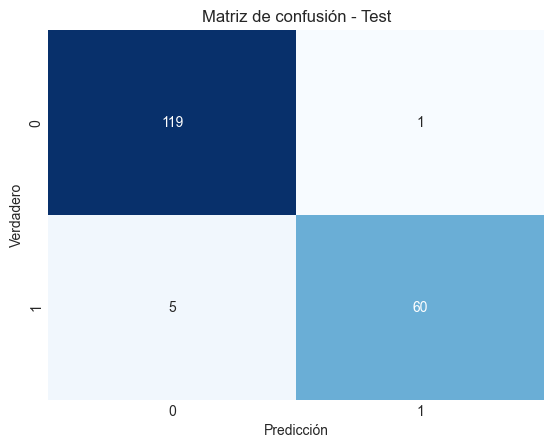

In [15]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
ax.set_xlabel("Predicción")
ax.set_ylabel("Verdadero")
ax.set_title("Matriz de confusión - Test")
plt.show()

## Diagnóstico de Sesgo-Varianza

Utilizamos las funciones de diagnóstico para analizar el equilibrio entre sesgo y varianza.

In [16]:
# Ejecutar diagnóstico
diagnosis = diagnose_bias_variance(
    dt_classifier,
    X_train, y_train,
    X_test,  y_test
)

# Formatear y mostrar resultados
df_diag = pd.DataFrame.from_dict(
    diagnosis, orient="index", columns=["Valor"]
)
df_diag.index.name = "Métrica"
display(df_diag)

,Valor
Métrica,
train_accuracy,0.96477
test_accuracy,0.967568
accuracy_difference,-0.002798
conclusion,El modelo tiene buen rendimiento en ambos conj...


## Curva de Aprendizaje

La curva de aprendizaje nos muestra cómo cambia el rendimiento del modelo a medida que aumenta el tamaño del conjunto de entrenamiento.

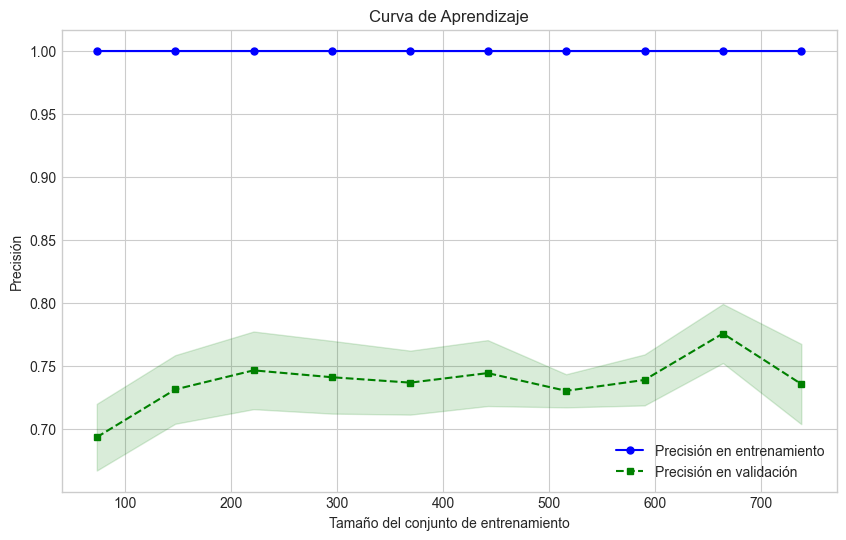

In [13]:
# Curva de aprendizaje
plt = plot_learning_curve(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    X, y, cv=5, n_jobs=-1
)
plt.savefig('../reports/figures/model_performance/learning_curve.png')

## Análisis de Complejidad del Modelo

Analizamos cómo afecta la complejidad del modelo (profundidad del árbol) al rendimiento en entrenamiento y prueba.

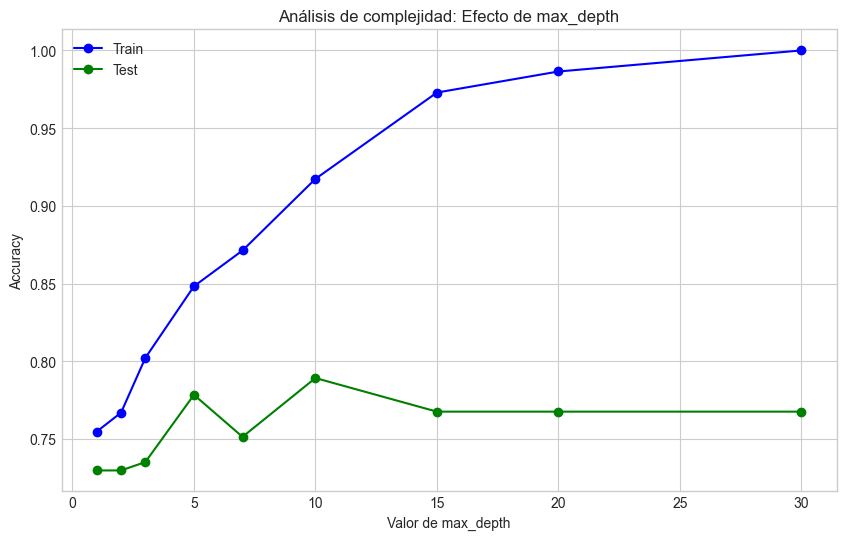

In [11]:
# Análisis de complejidad: profundidad máxima del árbol
max_depths = [1, 2, 3, 5, 7, 10, 15, 20, 30, None]
plt = plot_complexity_analysis(
    DecisionTreeClassifier,
    X_train, X_test, y_train, y_test,
    param_name="max_depth",
    param_range=max_depths,
    random_state=RANDOM_STATE
)
plt.savefig('../reports/figures/model_performance/complexity_analysis.png')

## Curva de Validación para otros Parámetros

Analizamos el efecto de otros parámetros de regularización.

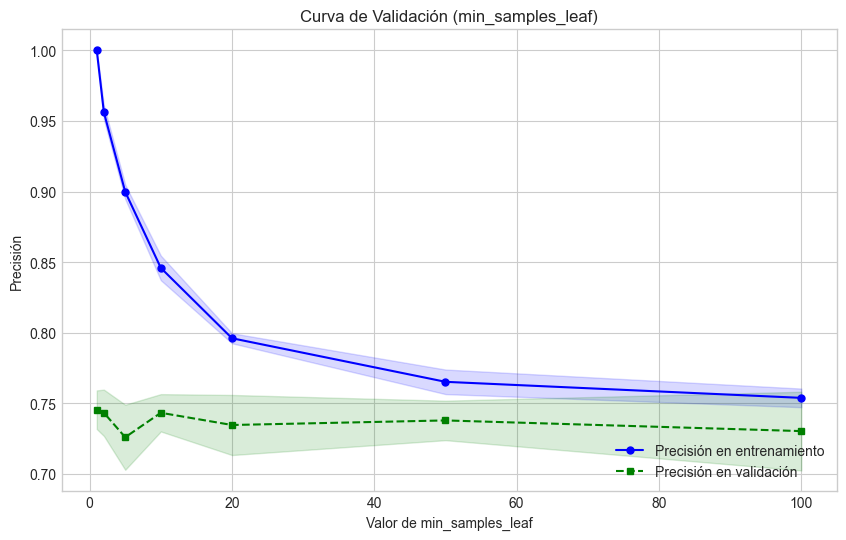

In [12]:
# Curva de validación para min_samples_leaf
min_samples_leaf_range = [1, 2, 5, 10, 20, 50, 100]
plt = plot_validation_curve(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    X, y,
    "min_samples_leaf",
    min_samples_leaf_range,
    cv=5, n_jobs=-1
)
plt.savefig('../reports/figures/model_performance/validation_curve.png')

## Validación Cruzada

Utilizamos validación cruzada para obtener una estimación más robusta del rendimiento del modelo.

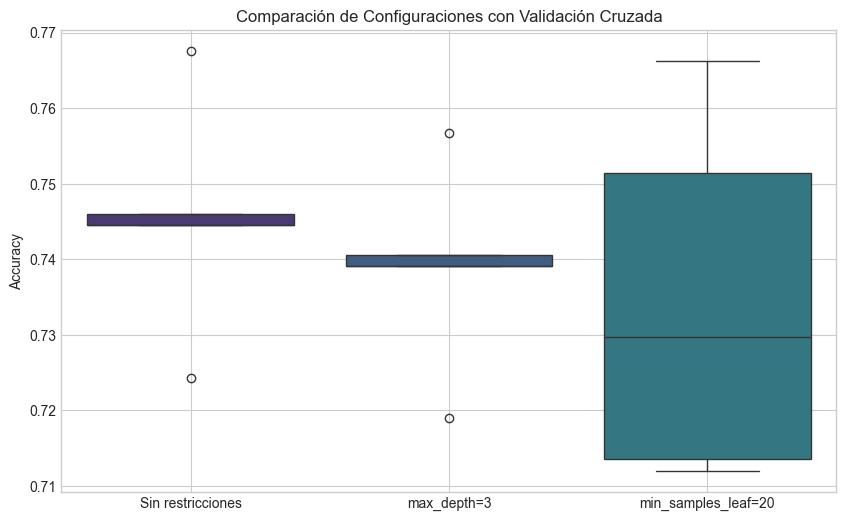

Medias y desviaciones estándar:
Sin restricciones: 0.7454 ± 0.0137
max_depth=3: 0.7389 ± 0.0120
min_samples_leaf=20: 0.7346 ± 0.0213


In [14]:
# Validación cruzada con diferentes configuraciones
cv_results = {}

# Árbol sin restricciones
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
cv_results['Sin restricciones'] = scores

# Árbol con max_depth=3
dt_shallow = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
scores = cross_val_score(dt_shallow, X, y, cv=5, scoring='accuracy')
cv_results['max_depth=3'] = scores

# Árbol con min_samples_leaf=20
dt_pruned = DecisionTreeClassifier(min_samples_leaf=20, random_state=RANDOM_STATE)
scores = cross_val_score(dt_pruned, X, y, cv=5, scoring='accuracy')
cv_results['min_samples_leaf=20'] = scores

# Visualizar resultados
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Comparación de Configuraciones con Validación Cruzada')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('../reports/figures/model_performance/cross_validation.png')
plt.show()

# Mostrar medias y desviaciones estándar
print("Medias y desviaciones estándar:")
for config, scores in cv_results.items():
    print(f"{config}: {scores.mean():.4f} ± {scores.std():.4f}")

## Análisis de Características Importantes

Examinamos qué características son más importantes para el modelo, lo que puede ayudar a identificar posibles fugas de datos.

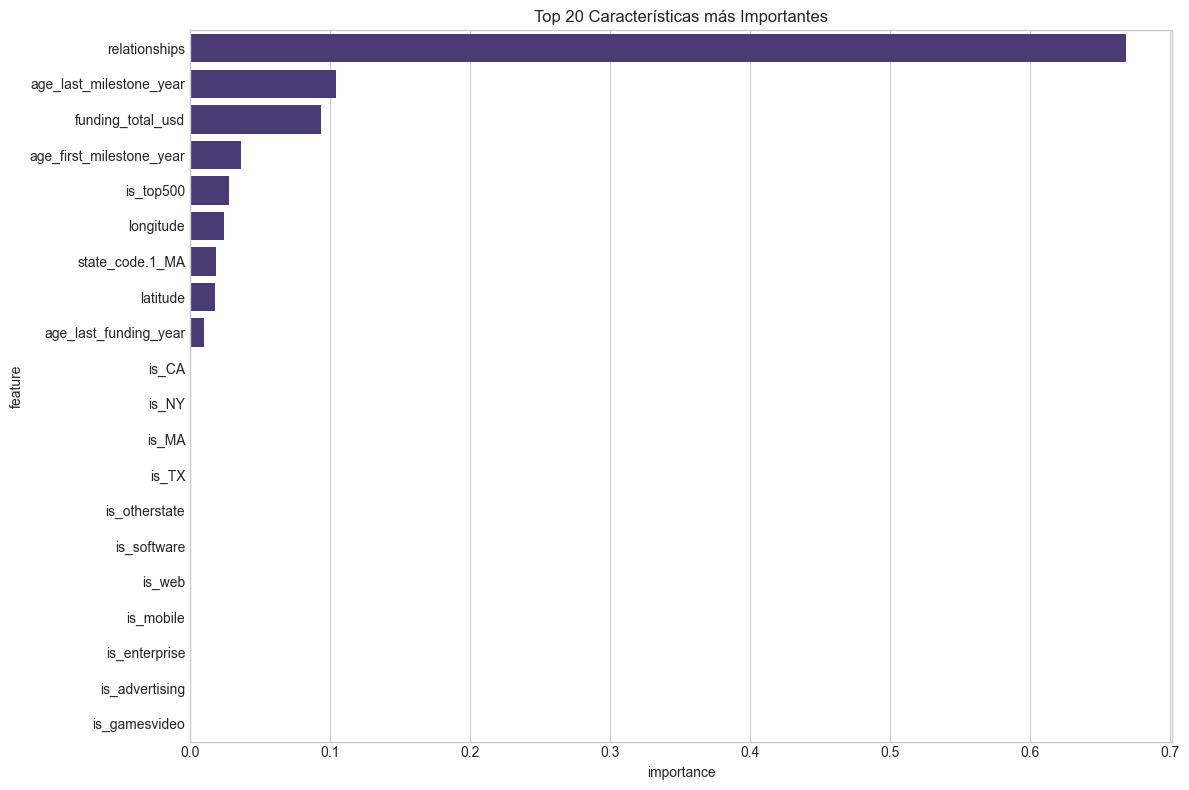

Las 10 características más importantes:
                    feature  importance
0             relationships    0.668127
1   age_last_milestone_year    0.104074
2         funding_total_usd    0.093524
3  age_first_milestone_year    0.036448
4                 is_top500    0.027684
5                 longitude    0.024016
6           state_code.1_MA    0.018286
7                  latitude    0.018062
8     age_last_funding_year    0.009778
9                     is_CA    0.000000


In [15]:
# Obtener importancia de características
feature_importances = dt_classifier.feature_importances_
feature_names = X.columns

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Mostrar las 20 características más importantes
top_20 = importance_df.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_20)
plt.title('Top 20 Características más Importantes')
plt.tight_layout()
plt.savefig('../reports/figures/model_performance/feature_importance.png')
plt.show()

# Imprimir las 10 más importantes
print("Las 10 características más importantes:")
print(importance_df.head(10))

### Conclusión
- El análisis realizado muestra que el modelo de árbol de decisión presenta un equilibrio razonable entre sesgo y varianza, con una diferencia moderada entre el rendimiento en entrenamiento y validación. Las curvas de aprendizaje y validación confirman que el modelo tiende a sobreajustar si no se regula, pero responde bien a la regularización mediante hiperparámetros como max_depth y min_samples_leaf.

- La validación cruzada evidencia que las diferentes configuraciones del árbol ofrecen resultados similares en cuanto a accuracy, lo que sugiere que el límite de mejora está más en los datos que en la complejidad del modelo. El análisis de importancia de variables revela que características como relationships y los hitos de la startup son las más influyentes en la predicción del éxito.

- En conjunto, los resultados son coherentes y realistas para el problema planteado, permitiendo comprender tanto el comportamiento del modelo como los factores clave que afectan el éxito de las startups. El flujo de trabajo seguido es sólido y deja la base preparada para experimentar con modelos más avanzados o técnicas de interpretación adicionales si se desea.